# Weather Only Model

## Packages

In [1]:
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import dask
import os
import glob
import geopandas as gpd
import xagg as xa
from linearmodels.panel import PanelOLS
from scipy.stats import gaussian_kde, skew, kurtosis
from matplotlib.gridspec import GridSpec

## Functions

In [42]:
def train_fe(file_path_SM_hist):
    '''
    given the file path from the preious jupyter notebooks, outputs the model 
    inputs
    - the file path of yearly aggregated feols regressors
    outputs
    - fips_level_inputs_pd as the clean dataset
    '''
    fips_level_inputs_pd = pd.read_csv(file_path_SM_hist) 
    fips_level_inputs_pd = fips_level_inputs_pd.rename(columns={'time': 'year'})
    fips_level_inputs_pd['year_input'] = fips_level_inputs_pd['year']
    fips_level_inputs_pd['year2'] = fips_level_inputs_pd['year']**2
    fips_level_inputs_pd['fips'] = fips_level_inputs_pd['fips'].astype(str).str.zfill(5)
    fips_level_inputs_pd['state'] = fips_level_inputs_pd['fips'].astype(str).str.slice(0, 2)
    return fips_level_inputs_pd

def eff_se_for_m(m):
    d = pd.Series(0.0, index=results_h21.params.index)
    d['SoilM_0_100cm'] = (m - m0) / number_of_days
    d['SoilM_0_100cm_square']  = (m*m - m0*m0) / number_of_days
    
    if SQUARE_IS_MEAN_OF_SQUARES:
        # this is the case sm was square before mean 
        d['SoilM_0_100cm_square'] = ((m**2) - (m0**2)) / number_of_days
    else:
        # this is the case of sm was mean before squaring
        d['SoilM_0_100cm_square'] = 2.0 * m0 * d['SoilM_0_100cm']
        
    b  = results_h21.params.reindex(d.index).fillna(0.0).values
    theta = covariance.reindex(index=d.index, columns=d.index).fillna(0.0).values
    x  = d.values
    eff = 100.0 * float(x @ b)
    se  = 100.0 * float(np.sqrt(x @ theta @ x))
    return eff, se

def futureYield(file_pattern_i, results_h21_yield, fixed_effects_no_time_unique_yield):
    '''
    Given a file path of yearly aggregated regressors calculates future corn yield projections 
    This function must be ran after the model is trained on the historical period (as done above with haqiqi et al method)
    inputs
    - file_pattern_i which is the path to the file path we are interested in (this comes from script 6)
    - results_h21_yield which is model specfic params 
    - fixed_effects_no_time_unique_yield which is model specific fixed effects
    outputs
    - pandas dataframe which includes fips and year as multi-index and prediction as column (of log corn yield)
    - pattern_name_i which is a cleaned pattern name corresponding to the future projections
    '''
    pattern_name = file_pattern_i.split("/")[-1]
    single_model = pd.read_csv(file_pattern_i)
    single_model['fips'] = single_model['fips'].astype(str).str.zfill(5)
    single_model['state'] = single_model['fips'].astype(str).str.slice(0, 2)
    single_model['year_input'] = single_model['year'].astype(float)
    single_model['year2'] = (single_model['year']**2).astype(float)
    single_model['SoilM_0_100cm_square'] = single_model['SoilM_0_100cm']**2
    # this is distinct and important to only retain valid states 
    single_model = single_model[single_model['fips'].isin(valid_fips)]
    single_model = single_model.set_index(['fips', 'year'])
    # we now go through each column multiplying it by its respective \beta_{i}
    new_predictions_no_effects = results_h21_yield.predict(data=single_model, effects=True)
    new_predictions_no_effects = new_predictions_no_effects.reset_index('year') # predictions
    merged_df_predictions_fixed = pd.merge(new_predictions_no_effects, fixed_effects_no_time_unique_yield, on='fips', how='inner')
    merged_df_predictions_fixed['total_pred'] = merged_df_predictions_fixed['predictions'] + merged_df_predictions_fixed['estimated_effects']
    merged_df_predictions_fixed = merged_df_predictions_fixed.reset_index()
    merged_df_predictions_fixed = merged_df_predictions_fixed.set_index(['fips', 'year'])
    return merged_df_predictions_fixed, pattern_name

def scalarYield(df_prediction_timespace, year, fips_code):
    '''
    Given df (like that of futureYield with fips, year, column), return the scalar corn yield for 
    certain combination of year and fips location
    '''
    return df_prediction_timespace.loc[fips_code, year]['total_pred'].item()

def weatherShocks(name_i, predictions_i, df_set_index_i, label_i, fips_number, state_number, hist_mean_exist=False, wf_fits=None):
    '''
    Given inputs / outputs for the econometric function haqiqi 2a, outputs the weather shocks i.e. the 
    haqiqi 2a model without the time trend and state level fixed effects, while also demeaning at the county level to give 
    essentially the weather contribution to the yield
    inputs:
    name_i as the string of the input specifics (i.e. model, nldas product ...) 
    results_h21_i as the results of the model
    predictions_i as the predictions of the model from the fit 
    df_set_index_i as the input i.e. the training dataset 
    label_i as the nldas soil moisture product for which the shocks are measured against. 
    outputs:
    weather_fit as the nonshock contribution
    weather_shock as the weather shocks
    '''
    if label_i == 'VIC':
        integer_index = 0
    elif label_i == 'NOAH':
        integer_index = 1
    elif label_i == 'MOS' or label_i == 'MOSAIC':
        integer_index = 2
        
    params = results_h21_arr[integer_index].params
    log_yield = results_h21_arr[integer_index].model.dependent
    estimate_effects = predictions_i['estimated_effects'].loc[fips_number]
    total_pred_series = predictions_i['total_pred'].loc[fips_number]
    valid_years  = predictions_i.loc[fips_number].index.values
    valid_years2 = valid_years**2
    yearcoeff = params[f'C(state)[T.{state_number}]:year_input'].item()
    year2coeff = params[f'C(state)[T.{state_number}]:year2'].item()
    time_trend = valid_years * yearcoeff + valid_years2 * year2coeff
    weather_fit = total_pred_series - time_trend - estimate_effects
    if hist_mean_exist == False:
        historical_mean = weather_fit.mean()
    elif hist_mean_exist == True:
        assert wf_fits is not None
        historical_mean = historicalWeatherMean(label_i, fips_number, wf_fits)
    weather_shock = weather_fit - historical_mean
    return weather_fit, weather_shock

def historicalWeatherMean(label_i, fips_number, wf_fits):
    '''
    given a nldas soil moisture string (MOS, VIC, NOAH) gives the weather fit for the historial perio.
    previously it was calculate the wf_arr are contains the historical fits.  wf_arr is in shape of sm_labels which is sm_labels = ['VIC', 'NOAH', 'MOSAIC']
    inputs
    - label_i as the nldas soil moisture string
    - fips_number as the fips number for the wf_fits
    - wf_fits as df of weather fits in order to demean at the county level for future projections 
    outputs
    - historical_mean as the mean 
    '''
    if label_i == 'MOSAIC' or label_i == 'MOS':
        historical_mean = wf_fits['fit'].loc[(slice(None), slice(None), 'MOSAIC')].mean()
    else:
        try:
            historical_mean = wf_fits['fit'].loc[(slice(None), slice(None), f'{label_i}')].mean()
        except ValueError:
            print("Unexpected soil moisture label string when computing historical_mean, (try MOSAIC?)")
    return historical_mean

def plot_kernel(time_frames):
    '''
    helper function to just plot the kernel density for n time frames
    input
    - time_frames as array 
    output
    - plot of n time_frames densities
    '''
    #time_frames = ["2045-2074"]
    ssps = ['ssp245', 'ssp370']
    #color_arr = ['#1f77b4', '#2ca02c', '#9467bd']
    #color_arr = ['#ff7f0e','#d62728', '#8c564b']
    color_arr = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
    
    for time_frame in time_frames:
        color_count = 0
        unique_model_names = sorted({pattern.split("/")[-1].split("_")[0] for pattern in glob.glob(f"{csv_output_file}*")})
        
        fips_code = '17113'
        plt.figure(figsize=(8,4))
        plt.title(f"Distribution Weather Shocks {time_frame} (H21, L21) \n fips = {fips_number}", fontsize=16)
        plt.xlabel("Log Corn Yields", fontsize=14)
        plt.ylabel("Probability Density", fontsize=14)
        for indx, label_i in enumerate(sm_labels):
            
            for ssp_i in ssps:
                time_series_list_for_maxnmin = []
                for model_name_i in unique_model_names:
                    corresponding_year_for_model_i_time_series = []
                    model_name_i_time_series = []
                    all_pattern_245 = sorted(glob.glob(f"{csv_output_file}{model_name_i}_r1i1p1f1_{ssp_i}_{label_i}_kge_{time_frame}_ddaysm.csv"))
                    for file_pattern_i in all_pattern_245:
                        df_predictions_future, pattern_name = futureYield(file_pattern_i, results_h21_arr[indx], fixed_effects_no_time_unique_arr[indx])
                        weather_fit, weather_shock = weatherShocks(pattern_name, df_predictions_future, df_set_index_i, label_i, hist_mean_exist=True)
                        #plt.plot(weather_shock)
                        time_series_list_for_maxnmin.append(weather_shock)
        
                time_series_list_for_maxnmin = np.concatenate(time_series_list_for_maxnmin).astype(float)
                xs = np.linspace(-1.75, 0.25, 400)
                kde = gaussian_kde(time_series_list_for_maxnmin)
                plt.plot(xs, kde(xs), color=color_arr[color_count], label=f'{ssp_i} {label_i}', lw=2)
                color_count += 1
            
            plt.legend(fontsize=16)

def weatherShock_df(name_i, predictions_i, df_set_index_i, hist_mean_exist=False, wf_fits=None):
    '''
    inputs
    - name_i as the soil_moisture label
    - predictions_i as the 
    - df_set_index_i
    outputs
    - ws_all as dataframe of weather shocks with soil_moisture label, year, and nldas training model as the columns. This contains shock & fit
    '''
    
    rows = []
    fips_list = predictions_i.index.get_level_values('fips').unique().tolist()
    for fips_number in fips_list:
        state_number = fips_number[:2]
        wf, ws = weatherShocks(name_i, predictions_i, df_set_index_i, name_i, fips_number, state_number, hist_mean_exist=hist_mean_exist, wf_fits=wf_fits)

        if hist_mean_exist == False:
            df_i = pd.DataFrame({
                'shock': ws.values,
                'fit': wf.values
            }, index=pd.MultiIndex.from_arrays(
                [np.repeat(fips_number, len(wf)), wf.index, np.repeat(name_i, len(wf))],
                names=['fips', 'year', 'sm_label']
            ))
            
        elif hist_mean_exist:
            df_i = pd.DataFrame({
                'shock': ws.values,
            }, index=pd.MultiIndex.from_arrays(
                [np.repeat(fips_number, len(ws)), ws.index, np.repeat(name_i, len(ws))],
                names=['fips', 'year', 'sm_label']
            ))
        rows.append(df_i)
    return rows 


def n_year_plot(name_i, shock_dataframe, year_min, year_maxp1, extra_label='', save_path=False, future = False):
    '''
    given some weather shock dataframe, the min year and max year plot a nxn subplot
    inputs
    - name_i as soilmoisture name
    - weather_shock_arr
    - year_min
    - year_maxp1
    outputs
    - plots & saves the fig
    '''
        
    fig = plt.figure(figsize=(9, 9))
    gs  = GridSpec(4, 3, height_ratios=[20, 20, 20, 1.2], wspace=0.0, hspace=0.0)
    axes = [fig.add_subplot(gs[r, c]) for r in range(3) for c in range(3)]
    cax  = fig.add_subplot(gs[-1, :])
    
    for ax_i, year_i in zip(axes, np.arange(year_min, year_max_p1)):
        ax_i.set_axis_off()
        ax_i.margins(0.035)
        
        single_M = shock_dataframe.loc[(slice(None), slice(year_i, year_i), name_i)]
        single_M = single_M.reset_index('fips')
        merged_map = counties.merge(single_M[['fips', 'shock']], on='fips', how='left')
        valid = merged_map.dropna(subset=['shock'])
        if not valid.empty:
            valid.plot(column='shock', cmap='coolwarm',
                       vmin=-0.5, vmax=0.5, ax=ax_i,
                       legend=False, edgecolor='none', zorder=2)
        
        last_mappable = ax_i.collections[-1]
        
        ax_i.text(0.96, 0.04, str(year_i),
                  transform=ax_i.transAxes, ha='right', va='bottom',
                  fontsize=15, fontweight='bold',
                  bbox=dict(facecolor='white', edgecolor='none', alpha=0.6, pad=2))
    cb = fig.colorbar(
        last_mappable, cax=cax, orientation='horizontal',
        ticks=np.linspace(-0.5, 0.5, 5),
        extend='both'
    )
    cb.set_label('ΔLog Yield (Bu/Ac)', fontsize=14)
    if future == False:
        string_type = 'Historical'
    if future:
        string_type = ' '
    fig.suptitle(f'{extra_label} {name_i}{string_type}Weather Shocks', fontsize=18, y=0.98)
    plt.subplots_adjust(top=0.95, bottom=0.10)
    if save_path:
        if future == False:
            plt.savefig(f"0_uncertainity_figures/0_hist_shocks/{name_i}_historical_weather_shocks_{year_min}_{year_max_p1-1}")
        if future:
            plt.savefig(f"0_uncertainity_figures/0_hist_shocks/{name_i}_{extra_label}_future_weather_shocks_{year_min}_{year_max_p1-1}")



In [3]:
csv_output_file_haqiqi2021_2aVIC = "/storage/home/cta5244/work/avila_et_al_2025_pyWBM_yield/data/VIC_csv_output_file_haqiqi2021_2a_normalgrowingssn_averageseason_averageyearsm.csv"
csv_output_file_haqiqi2021_2aNOAH = "/storage/home/cta5244/work/avila_et_al_2025_pyWBM_yield/data/NOAH_csv_output_file_haqiqi2021_2a_normalgrowingssn_averageseason_averageyearsm.csv"
csv_output_file_haqiqi2021_2aMOS = "/storage/home/cta5244/work/avila_et_al_2025_pyWBM_yield/data/MOS_csv_output_file_haqiqi2021_2a_normalgrowingssn_averageseason_averageyearsm.csv"

usda_filepath = "/storage/home/cta5244/work/avila_et_al_2025_pyWBM_yield/data/usda_historical_yields.csv"
county_shp_path = "/storage/work/cta5244/avila_et_al_2025_pyWBM_yield/shape_files/counties_contig_plot.shp"

sm_labels = ['VIC', 'NOAH', 'MOSAIC']

In [4]:
counties = gpd.read_file(county_shp_path)
usda_pd = pd.read_csv(usda_filepath)
usda_pd['fips'] = usda_pd['fips'].astype(str).str.zfill(5)
usda_pd['state'] = usda_pd['state'].astype(str).str.zfill(2)
usda_pd = usda_pd[['fips','year','yield', 'state']]
# Count occurrences of 'fips' and name the column 'n'
fips_counts = usda_pd.groupby('fips').size().reset_index(name='n')
# Merge the count back into the original DataFrame
usda_pd = usda_pd.merge(fips_counts, on='fips')
usda_pd = usda_pd[usda_pd["n"] >= 30]
usda_pd['log_yield'] = np.log(usda_pd['yield'])

In [5]:
fips_level_inputs_pd_VIC = train_fe(csv_output_file_haqiqi2021_2aVIC)
fips_level_inputs_pd_NOAH = train_fe(csv_output_file_haqiqi2021_2aNOAH)
fips_level_inputs_pd_MOS = train_fe(csv_output_file_haqiqi2021_2aMOS)
list_historic_sm = [fips_level_inputs_pd_VIC, fips_level_inputs_pd_NOAH, fips_level_inputs_pd_MOS]
df_set_index_arr = []
# merge usda_pd & histdata 
for soil_moisture_comibination_i in list_historic_sm:
    
    df = soil_moisture_comibination_i.merge(usda_pd, how='inner', on=['fips', 'year', 'state'])
    df['year2'] = df['year']**2
    
    rainfed_states = ["01", "05", "09", "10", "12", "13", "17", "18", "19", "20", 
                       "21", "22", "23", "24", "25", "26", "27", "28", "29", "31", 
                       "33", "34", "36", "37", "38", "39", "40", "42", "44", "45", 
                       "46", "47", "48", "50", "51", "54", "55"]
    
    df = df[df['state'].isin(rainfed_states)]
    df_set_index = df.set_index(['fips', 'year'])
    df_set_index_arr.append(df_set_index) # the arr of dataframes is ordered by the list_historic (so VIC then NOAH then MOS)

## Weather Only Component (Lafferty 2021 esque)
### $logY'_{i,t} = \beta_{1}GDD_{i,t} + \beta_{2}SM+ \beta_{3}SM^{2} + \beta_{\alpha}EDD_{binned} $
- We only want this component, and subtract off time trend and state fe
- This is showing the 'weather' component of the yield model, which is then demeaned.
- This demeaned plot is showing the yearly contribution of weather towards the yield (i.e. with no technological trend or state level fixed effects)

In [6]:
# define the model with compound extremes & state specific trends

formula = (
    'log_yield ~ gdd + edd_minus75 + edd_minus25_75 + edd_minus25_plus25 + '
    'edd_plus25_75 + edd_plus75 + SoilM_0_100cm + SoilM_0_100cm_square + '
    'C(state):year_input + C(state):year2 + EntityEffects'
)

model_arr = []
results_h21_arr = []
predictions_arr = []
for df_set_index_i in df_set_index_arr:
    model = PanelOLS.from_formula(formula, data=df_set_index_i)
    results_h21 = model.fit(cov_type='clustered', clusters=df_set_index_i['state'])
    predictions = results_h21.predict(effects=True)
    predictions['total_pred'] = predictions['fitted_values'] + predictions['estimated_effects']
    model_arr.append(model)
    results_h21_arr.append(results_h21)
    predictions_arr.append(predictions)

In [7]:
frames = []
for (name_i, predictions_i, df_set_index_i) in zip(sm_labels, predictions_arr, df_set_index_arr):
    df_label = weatherShock_df(name_i, predictions_i, df_set_index_i, hist_mean_exist=False, wf_fits=None)
    frames.extend(df_label)
ws_all_hist = pd.concat(frames).sort_index()


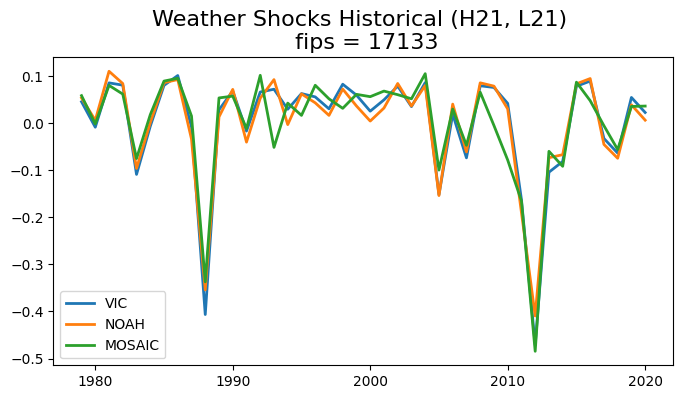

In [8]:
fips_number = '17133'
plt.figure(figsize=(8,4))
plt.title(f'Weather Shocks Historical (H21, L21) \n fips = {fips_number}', fontsize=16)
for name_i in sm_labels:
    yr = ws_all_hist['shock'].loc[('17113', slice(None), name_i)].index
    vals = ws_all_hist['shock'].loc[('17113', slice(None), name_i)].values
    plt.plot(yr, vals, lw=2, label=name_i)
plt.legend()

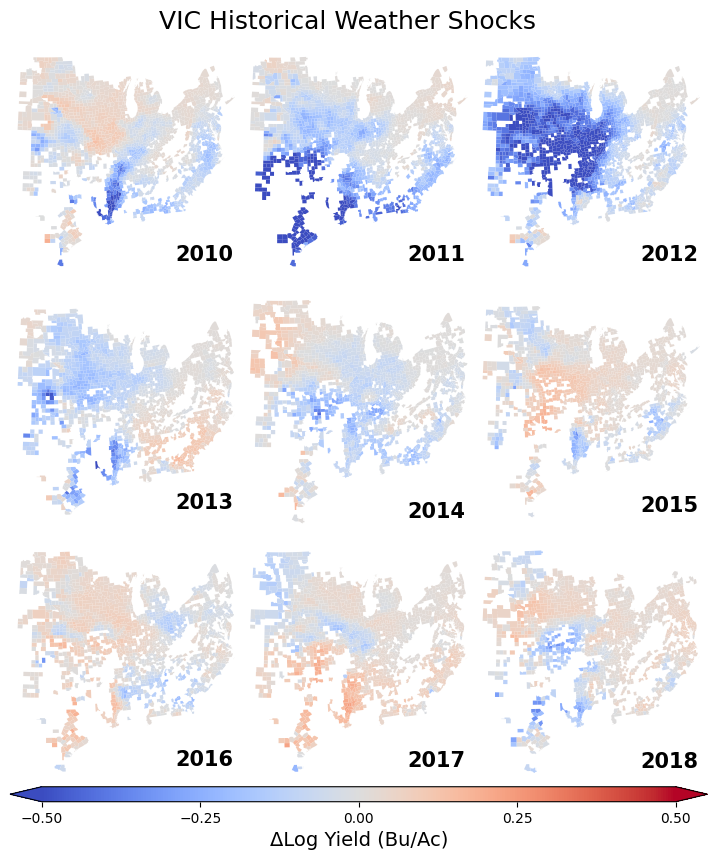

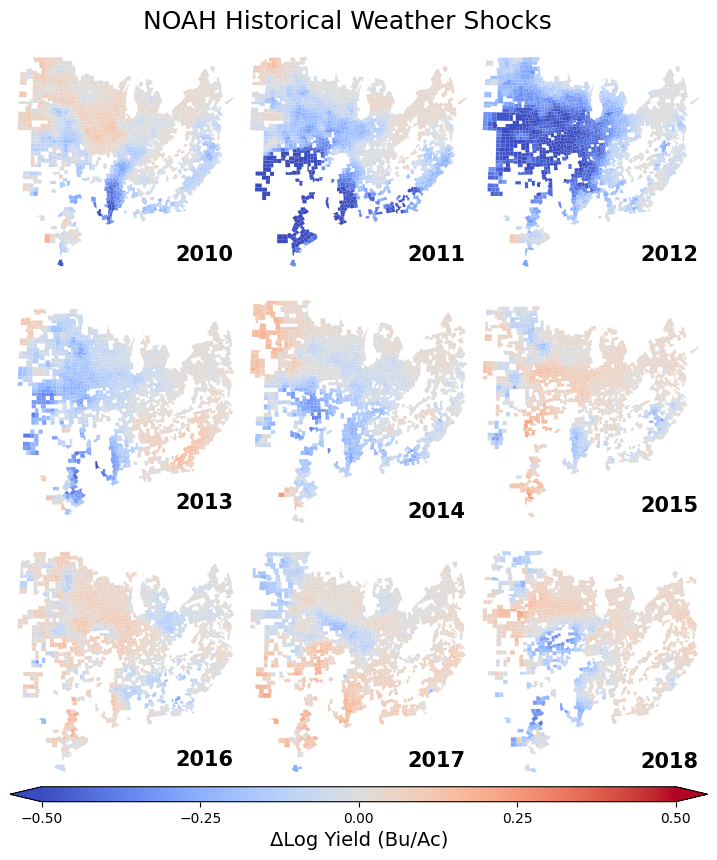

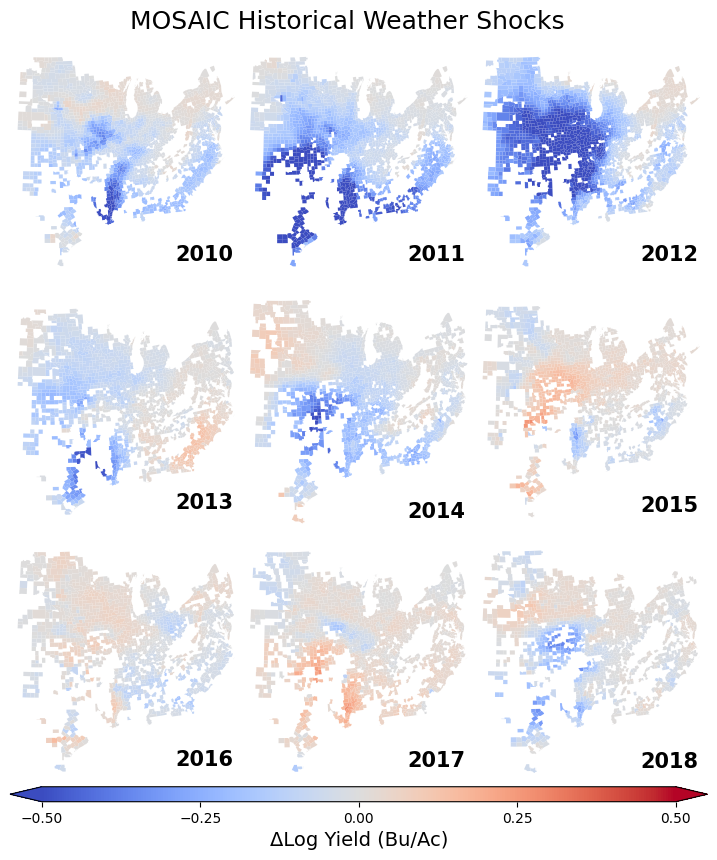

In [9]:
year_min = 2010
year_max_p1 = 2019
for name_i in sm_labels:
    n_year_plot(name_i, ws_all_hist, year_min, year_max_p1, save_path = False, future = False)


### Future projections 

In [9]:
csv_output_file = f"/storage/home/cta5244/work/pyWBM_yield_data/pyWBM_dday/"
# arbritrary path looks like /storage/home/cta5244/work/pyWBM_yield_data/pyWBM_dday/ACCESS-CM2_r1i1p1f1_ssp245_VIC_kge_2015-2044_ddaysm.csv 
all_pattern_370_VIC = sorted(glob.glob(f"{csv_output_file}*_ssp370_VIC_kge_2015-2044_ddaysm.csv"))
all_pattern_245_VIC = sorted(glob.glob(f"{csv_output_file}*_ssp245_VIC_kge_2015-2044_ddaysm.csv"))
all_pattern_370_NOAH = sorted(glob.glob(f"{csv_output_file}*_ssp370_NOAH_kge_2015-2044_ddaysm.csv"))
all_pattern_245_NOAH = sorted(glob.glob(f"{csv_output_file}*_ssp245_NOAH_kge_2015-2044_ddaysm.csv"))
all_pattern_370_MOS = sorted(glob.glob(f"{csv_output_file}*_ssp370_MOS_kge_2015-2044_ddaysm.csv"))
all_pattern_245_MOS = sorted(glob.glob(f"{csv_output_file}*_ssp245_MOS_kge_2015-2044_ddaysm.csv"))

# get fixed effects from the intial model run (above) 
fixed_effects_no_time_unique_arr, valid_fips_arr = [], []
for indx, results_h21_i in enumerate(results_h21_arr):
    fixed_effects_by_fips = results_h21_i.estimated_effects
    fixed_effects_no_time = fixed_effects_by_fips.reset_index(['fips', 'year']).drop('year', axis=1).drop_duplicates()
    fixed_effects_no_time_unique = fixed_effects_no_time.drop_duplicates(subset='fips', keep='first')
    fixed_effects_no_time_unique = fixed_effects_no_time_unique.set_index('fips')
    valid_fips = df_set_index.index.get_level_values('fips').unique()
    fixed_effects_no_time_unique_arr.append(fixed_effects_no_time_unique)
    valid_fips_arr.append(valid_fips)

## Time Series

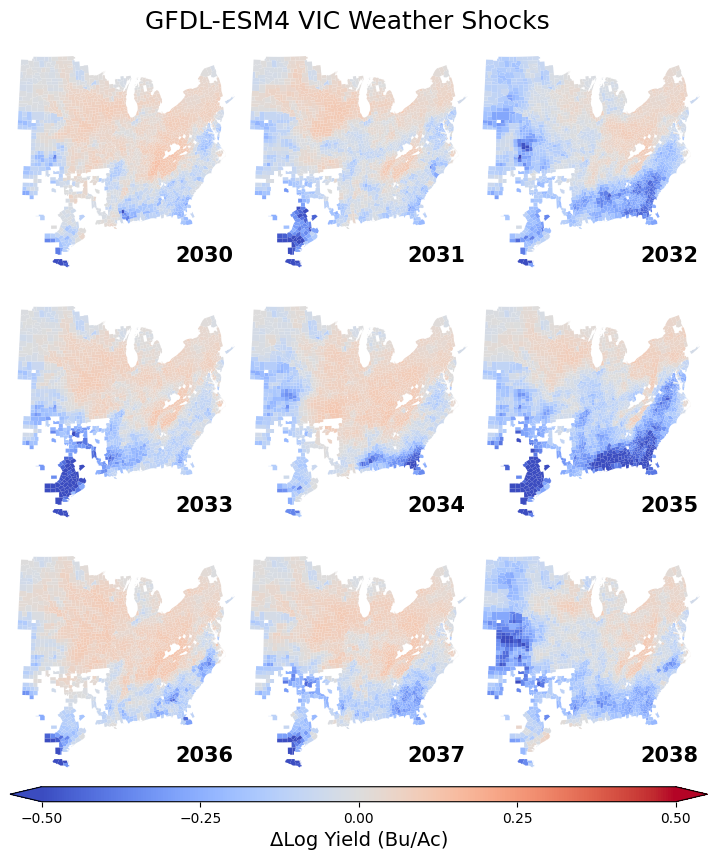

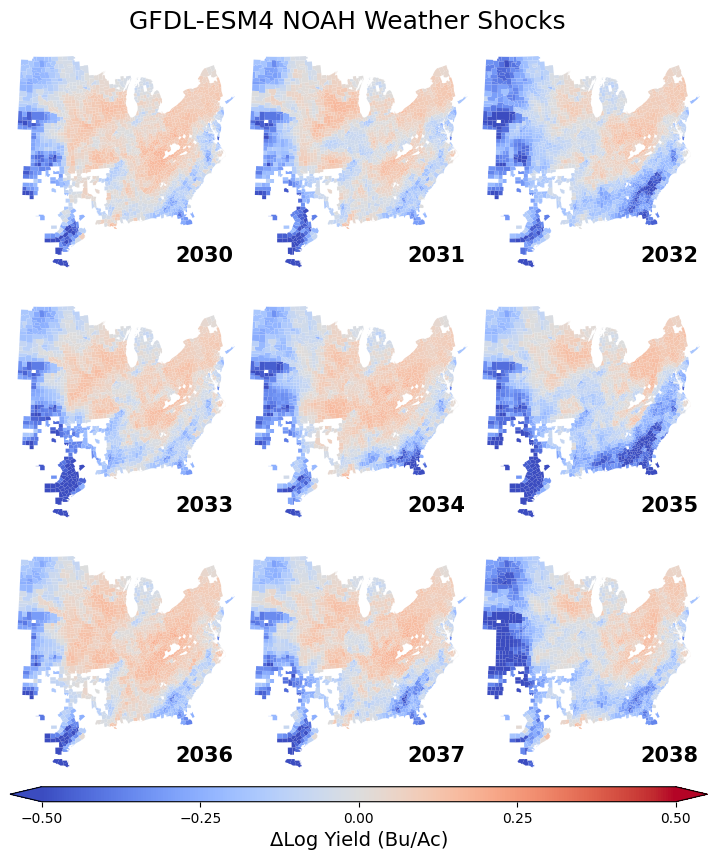

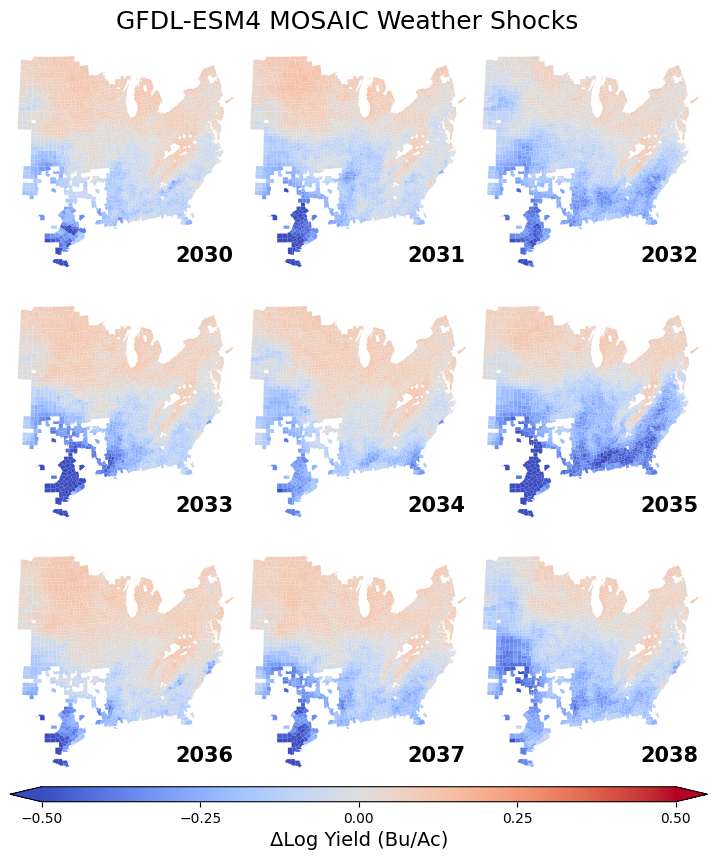

In [43]:
year_min = 2030
year_max_p1 = 2039
time_frames = ["2015-2044"]#, "2045-2074", "2075-2100"]
ssps = ['ssp245', 'ssp370']
unique_model_names = sorted({pattern.split("/")[-1].split("_")[0] for pattern in glob.glob(f"{csv_output_file}*")})

for indx, label_i in enumerate(sm_labels):
    
    for ssp_i in ssps[1:]:
        
        for model_name_i in unique_model_names[9:10]:
            
            all_pattern_245 = sorted(glob.glob(f"{csv_output_file}{model_name_i}_r1i1p1f1_{ssp_i}_{label_i}_kge_{time_frames[0]}_ddaysm.csv"))
            for file_pattern_i in all_pattern_245[:1]:
                df_predictions_future, pattern_name = futureYield(file_pattern_i, results_h21_arr[indx], fixed_effects_no_time_unique_arr[indx])
                ws_futures_list = weatherShock_df(label_i, df_predictions_future, df_set_index_i, hist_mean_exist=True, wf_fits=ws_all_hist)
                ws_futures = pd.concat(ws_futures_list).sort_index()
                n_year_plot(label_i, ws_futures, year_min, year_max_p1, extra_label=model_name_i, save_path=True, future = True)

## distributions

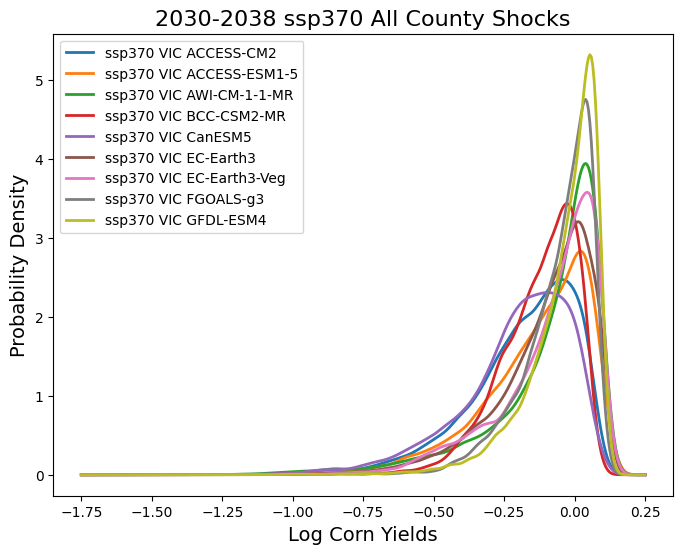

In [32]:
year_min = 2030
year_max_p1 = 2039
time_frames = ["2015-2044"]#, "2045-2074", "2075-2100"]
ssps = ['ssp245', 'ssp370']
xs = np.linspace(-1.75, 0.25, 400)

unique_model_names = sorted({pattern.split("/")[-1].split("_")[0] for pattern in glob.glob(f"{csv_output_file}*")})

plt.figure(figsize=(8,6))

for indx, label_i in enumerate(['VIC']):

    for ssp_i in ssps[1:]:
        plt.title(f'{year_min}-{year_max_p1-1} {ssp_i} All County Shocks', fontsize=16)
        plt.xlabel("Log Corn Yields", fontsize=14)
        plt.ylabel("Probability Density", fontsize=14)
        for model_name_i in unique_model_names[:10]:
            all_pattern_245 = sorted(glob.glob(f"{csv_output_file}{model_name_i}_r1i1p1f1_{ssp_i}_{label_i}_kge_{time_frames[0]}_ddaysm.csv"))
            for file_pattern_i in all_pattern_245[:1]:
                df_predictions_future, pattern_name = futureYield(file_pattern_i, results_h21_arr[indx], fixed_effects_no_time_unique_arr[indx])
                ws_futures_list = weatherShock_df(label_i, df_predictions_future, df_set_index_i, hist_mean_exist=True, wf_fits=ws_all_hist)
                ws_futures = pd.concat(ws_futures_list).sort_index()
                single_model_all_shocks = (ws_futures.loc[(slice(None), slice(year_min, year_max_p1-1), 'VIC')]['shock'].values)
                kde = gaussian_kde(single_model_all_shocks)
                plt.plot(xs, kde(xs), label=f'{ssp_i} {label_i} {model_name_i}', lw=2)
                
    plt.legend()

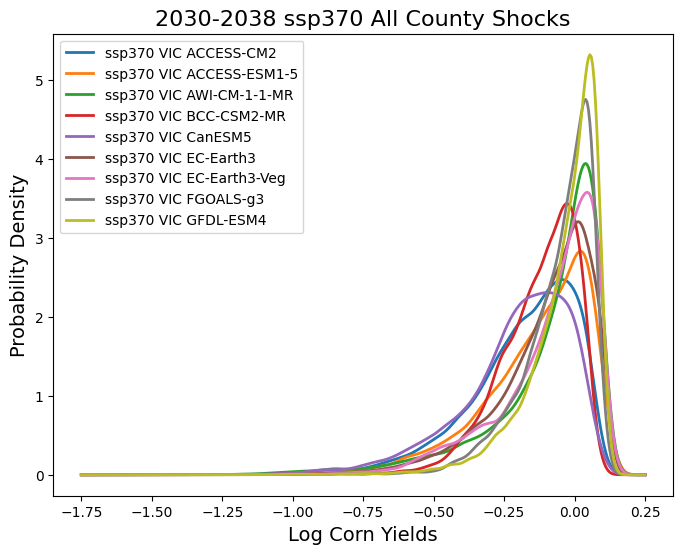

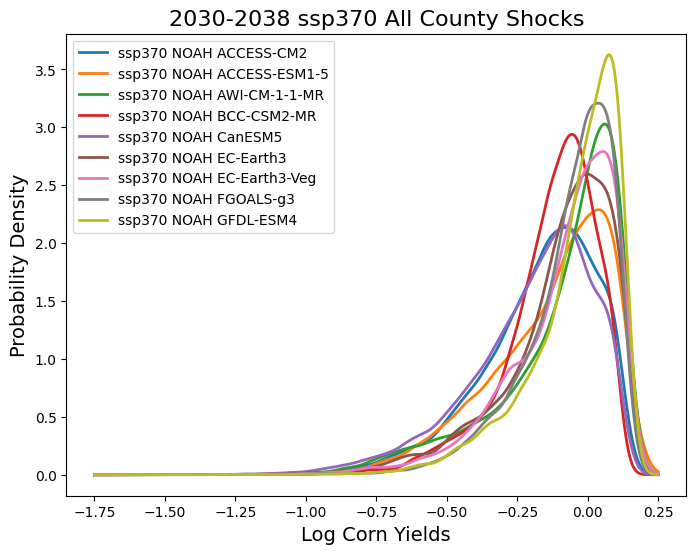

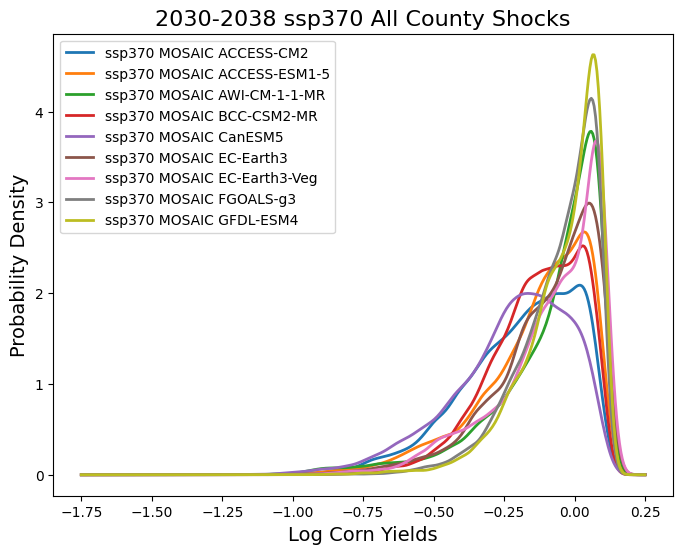

In [47]:
year_min = 2030
year_max_p1 = 2039
time_frames = ["2015-2044"]#, "2045-2074", "2075-2100"]
ssps = ['ssp245', 'ssp370']
xs = np.linspace(-1.75, 0.25, 400)

unique_model_names = sorted({pattern.split("/")[-1].split("_")[0] for pattern in glob.glob(f"{csv_output_file}*")})

for indx, label_i in enumerate(sm_labels):
    plt.figure(figsize=(8,6))
    plt.title(f'{year_min}-{year_max_p1-1} ssp370 All County Shocks', fontsize=16)
    plt.xlabel("Log Corn Yields", fontsize=14)
    plt.ylabel("Probability Density", fontsize=14)
    for ssp_i in ssps[1:]:
        for model_name_i in unique_model_names[:10]:
            all_pattern_245 = sorted(glob.glob(f"{csv_output_file}{model_name_i}_r1i1p1f1_{ssp_i}_{label_i}_kge_{time_frames[0]}_ddaysm.csv"))
            for file_pattern_i in all_pattern_245[:1]:
                df_predictions_future, pattern_name = futureYield(file_pattern_i, results_h21_arr[indx], fixed_effects_no_time_unique_arr[indx])
                ws_futures_list = weatherShock_df(label_i, df_predictions_future, df_set_index_i, hist_mean_exist=True, wf_fits=ws_all_hist)
                ws_futures = pd.concat(ws_futures_list).sort_index()
                single_model_all_shocks = (ws_futures.loc[(slice(None), slice(year_min, year_max_p1-1), label_i)]['shock'].values)
                kde = gaussian_kde(single_model_all_shocks)
                plt.plot(xs, kde(xs), label=f'{ssp_i} {label_i} {model_name_i}', lw=2)
                
    plt.legend()

## Frequency Survival Analysis